# Sensing Matrix Diagonalization
In this tutorial, we will demonstration the use of `kontrol.SensingMatrix` class to diagonalize a pair of coupled sensors.

Here, suppose we have two displacements $x_1$ and $x_2$, and we have sensing readouts $s_1$ and $s_2$.
We kicked the system and let it resonates. $x_1$ is a damped oscillation at $1\ \mathrm{Hz}$ and $x_2$ is a damped oscillation at $3\ \mathrm{Hz}$. We hard code sensing coupling $s_1 = x_1 + 0.1x_2$ and $s_2 = -0.2x_1 + x_2$.
For simplicity, let's assume that these sesning readouts are obtained using an initial sensing matrix of $\mathbf{C}_\mathrm{sensing, initial}=\begin{bmatrix}1&0\\0&1\end{bmatrix}$.

We will estimate the coupling ratios from the spectra of $s_1$ and $s_2$, and let's see if we can recover a sensing matrix $\mathbf{C}_\mathrm{sensing}$ such that $\left[x_1,\,x_2\right]^T=\mathbf{C}_\mathrm{sensing}\left[s_1,\,s_2\right]^T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fs = 1024
t_ini = 0
t_end = 100
t = np.linspace(0, 100, (t_end-t_ini)*fs)
np.random.seed(123)
x_1_phase = np.random.uniform(0, np.pi)
x_2_phase = np.random.uniform(0, np.pi)
x_1 = np.real(1.5 * np.exp((-0.1+(2*np.pi*1)*1j) * t + x_1_phase*1j))
x_2 = np.real(3 * np.exp((-0.2+(2*np.pi*3)*1j) * t + x_2_phase*1j))
s_1 = x_1 + 0.1*x_2
s_2 = -0.2*x_1 + x_2

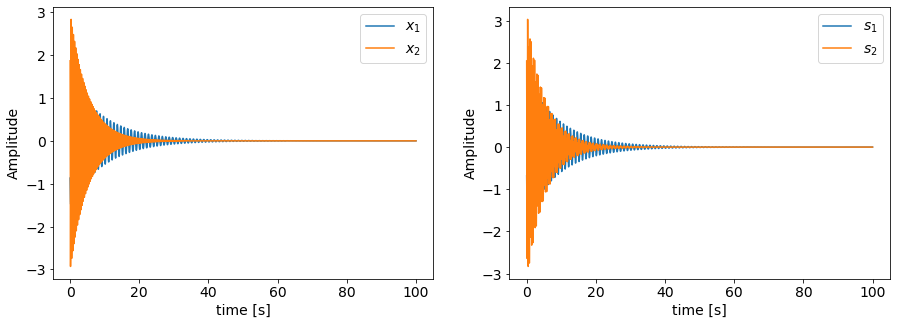

In [2]:
plt.rcParams.update({"font.size": 14})
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(t, x_1, label="$x_1$")
plt.plot(t,x_2, label="$x_2$")
plt.ylabel("Amplitude")
plt.xlabel("time [s]")
plt.legend(loc=0)

plt.subplot(122)
plt.plot(t, s_1, label="$s_1$")
plt.plot(t, s_2, label="$s_2$")
plt.ylabel("Amplitude")
plt.xlabel("time [s]")
plt.legend(loc=0)

Now, let's obtain various spectra of the sensor readouts, like how we would use diaggui to obtain spectral densities and transfer functions.

In [3]:
import scipy.signal
fs = 1/(t[1]-t[0])
f, psd_s_1 = scipy.signal.welch(s_1, fs=fs, nperseg=int(len(s_1)/5))
f, psd_s_2 = scipy.signal.welch(s_2, fs=fs, nperseg=int(len(s_2)/5))
f, csd_s_12 = scipy.signal.csd(s_1, s_2, fs=fs, nperseg=int(len(s_1)/5))

mask = f>0
f = f[mask]
psd_s_1 = psd_s_1[mask]
psd_s_2 = psd_s_2[mask]
csd_s_12 = csd_s_12[mask]

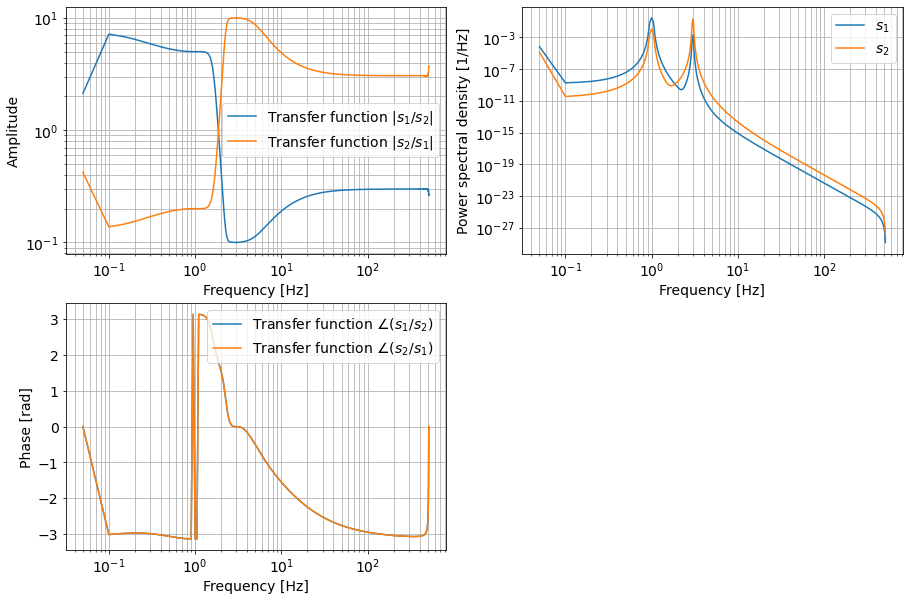

In [4]:
plt.figure(figsize=(15, 10))

plt.subplot(221)
plt.loglog(f, abs(csd_s_12/psd_s_2), label="Transfer function $|s_1/s_2|$")
plt.loglog(f, abs(csd_s_12/psd_s_1), label="Transfer function $|s_2/s_1|$")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(222)
plt.loglog(f, psd_s_1, label="$s_1$")
plt.loglog(f, psd_s_2, label="$s_2$")
plt.ylabel("Power spectral density [1/Hz]")
plt.xlabel("Frequency [Hz]")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(223)
plt.semilogx(f, np.angle(csd_s_12/psd_s_2), label=r"Transfer function $\angle\left(s_1/s_2\right)$")
plt.semilogx(f, np.angle(csd_s_12/psd_s_1), label=r"Transfer function $\angle\left(s_2/s_1\right)$")
plt.ylabel("Phase [rad]")
plt.xlabel("Frequency [Hz]")
plt.legend(loc=0)
plt.grid(which="both")

Now, we know that the resonance frequencies are at 1 Hz and 3 Hz, so we can safely assume that these frequencies are purely $x_1$ and $x_2$ motion respectively. We see that the transfer functions $s_1/s_2$ and $s_2/s_1$ have flat response at these frequencies. These correspond to coupling ratios $s_1/x_2$ (at 3 Hz) and $s_2/x_1$ (at 3 Hz). From the phase response, we see that the phase between $x_2$ and $s_1$ is 0, and that between $x_1$ and $s_2$ is at $-\pi$, this correspond to a minus sign in the coupling ratio. Let's inspect further.

In [5]:
# f_1hz = f[(f>0.9) & (f<1.1)]
# f_3hz = f[(f>2.9) & (f<3.1)]
print(r"Coupling ratio $s_1/x_2$", np.mean(abs(csd_s_12/psd_s_2)[(f>2.9) & (f<3.1)]))
print(r"Coupling ratio $s_2/x_1$", np.mean(abs(csd_s_12/psd_s_1)[(f>0.9) & (f<1.1)]))
print(r"Phase $s_1/x_2$", np.angle(csd_s_12/psd_s_2)[(f>2.9) & (f<3.1)])
print(r"Phase $s_2/x_1$", np.angle(csd_s_12/psd_s_1)[(f>0.9) & (f<1.1)])

Coupling ratio $s_1/x_2$ 0.10001284705931585
Coupling ratio $s_2/x_1$ 0.19997798568604752
Phase $s_1/x_2$ [-8.05189656e-05 -8.56070819e-06  8.71342862e-05 -1.62118769e-04]
Phase $s_2/x_1$ [ 3.14151356 -3.14157211 -3.14157723  3.14037366]


Indeed, we find coupling ratios 0.100013 and -0.199978.

Now, we assume the follow:

$\mathbf{C}_\mathrm{coupling}\left[x_1,\,x_2\right]^T=\mathbf{C}_\mathrm{sensing, initial}\left[s_1,\,s_2\right]^T$, so the coupling matrix $\mathbf{C}_\mathrm{coupling} $ is $\begin{bmatrix}1&0.100013\\-0.199978&1\end{bmatrix}$.

And now let's use `kontrol.SensingMatrix` to compute a new sensing matrix.

In [6]:
import kontrol

c_sensing_initial = np.array([[1, 0], [0, 1]])
c_coupling = np.array([[1, 0.100013], [-0.199978, 1]])


sensing_matrix = kontrol.SensingMatrix(matrix=c_sensing_initial, coupling_matrix=c_coupling)
## Alternatively,
## sensing_matrix = kontrol.SensingMatrix(matrix=c_sensing_initial)
## sensing_matrix.coupling_matrix = c_coupling

## Now diagonalize
c_sensing = sensing_matrix.diagonalize()
## Alternatively
## c_sensing = sensing_matrix.diagonalize(coupling_matrix=c_coupling)

print(c_sensing)

[[ 0.98039177 -0.09805192]
 [ 0.19605679  0.98039177]]


Now let's test the new matrix.

We compute the new sensing readout $\left[s_{1,\mathrm{new}},\,s_{2,\mathrm{new}}\right]^T = \mathbf{C}_\mathrm{sensing}\left[s_1,\,s_2\right]^T$, and then compute the power spectral densities and compare it with the old ones.

In [7]:
s_new = c_sensing @ np.array([s_1, s_2])
s_1_new = s_new[0]
s_2_new = s_new[1]

f, psd_s_1_new = scipy.signal.welch(s_1_new, fs=fs, nperseg=int(len(s_1_new)/5))
f, psd_s_2_new = scipy.signal.welch(s_2_new, fs=fs, nperseg=int(len(s_2_new)/5))
f, csd_s_12_new = scipy.signal.csd(s_1_new, s_2_new, fs=fs, nperseg=int(len(s_1_new)/5))

mask = f>0
f = f[mask]
psd_s_1_new = psd_s_1_new[mask]
psd_s_2_new = psd_s_2_new[mask]
csd_s_12_new = csd_s_12_new[mask]

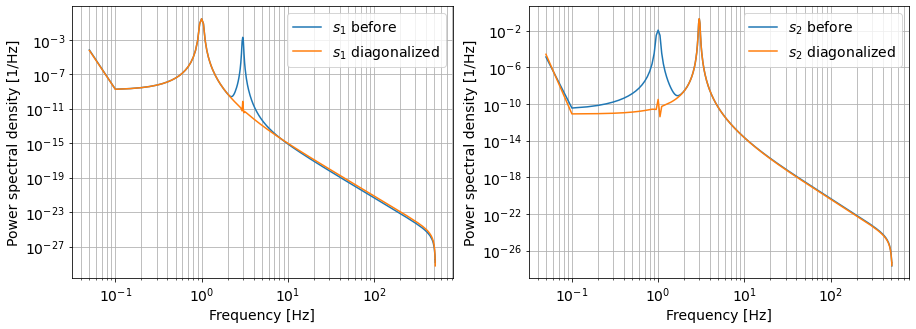

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.loglog(f, psd_s_1, label="$s_1$ before")
plt.loglog(f, psd_s_1_new, label="$s_1$ diagonalized")
plt.ylabel("Power spectral density [1/Hz]")
plt.xlabel("Frequency [Hz]")
plt.legend(loc=0)
plt.grid(which="both")

plt.subplot(122)
plt.loglog(f, psd_s_2, label="$s_2$ before")
plt.loglog(f, psd_s_2_new, label="$s_2$ diagonalized")
plt.ylabel("Power spectral density [1/Hz]")
plt.xlabel("Frequency [Hz]")
plt.legend(loc=0)
plt.grid(which="both")

As we can see, the couplings have been reduced by many many orders of magnitudes, while the diagonal readout remains the same.

By the way. `kontrol.SensingMatrix` class inherit `numpy.ndarray`, so you can do any numpy array operation on it.
For example,

In [9]:
sensing_matrix + np.random.random(np.shape(sensing_matrix))

SensingMatrix([[1.22685145, 0.55131477],
               [0.71946897, 1.42310646]])